### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Nadam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
data_folder = "data/"

In [5]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [6]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(data_folder + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
import pandas as pd
def convert_to_data_frame(model_name, data):
    df = pd.DataFrame.from_records(data)
    df['name'] = model_name
    return df

In [8]:
from itertools import product

hp_learning_rate = [0.001]
hp_gamma = [0.95]
decay_rate = [0.0003]
layers = [[128, 128], [128, 64, 32], [256, 256]]

hp_params = list(product(hp_learning_rate, hp_gamma, decay_rate, layers))

In [9]:
def get_model_name(params):
    name = "3_lr_" + str(params[0]) + "_gamma_" + str(
        params[1]) + "_decay_rate_" + str(params[2]) + "_layers_" + '_'.join(
            str(x) for x in params[3])
    return name

In [10]:
def plot_tracked_values(states_tracks, name=None, big=False):
    if big:
        row = 2
        column = 2
        figsize = (16, 12)
    else:
        row = 1
        column = 4
        figsize = (16, 4)

    fig, axs = plt.subplots(row, column, figsize=figsize)
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(states_tracks[tracked_value[0]][tracked_value[1]])))
        plt.subplot(row, column, index + 1)
        plt.plot(xaxis,
                 np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]))
        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
    if name:
        fig.suptitle(name, fontsize=16)
    plt.show()

In [11]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [12]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [13]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [14]:
class DQNAgent:
    def __init__(self,
                 agent_param,
                 state_encoder,
                 name="DQNAgent",
                 verbose=False):
        if verbose:
            agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space
        self.name = name
        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1
        self.verbose = verbose

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Nadam(lr=self.learning_rate))
        if self.verbose:
            model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def save_tracking_states(self):
        save_obj(self.states_track, self.name + '_tracked_states')

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [15]:
env = CabDriver()

In [16]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

### DQN block

In [17]:
def q_learning(params, max_epsilon=1.0, episodes=50000, verbose=False):
    name = get_model_name(params)
    lr = params[0]
    gamma = params[1]
    decay_rate = params[2]
    layers = params[3]
    log_threshold = episodes * .001
    threshold = episodes * .001
    model_threshold = episodes * 0.01

    print("learning_rate", lr)
    print("gamma", gamma)
    print("decay_rate", decay_rate)
    print("max_epsilon", max_epsilon)
    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("model_threshold", model_threshold)

    start_time = time.time()
    agent_param_dict = {
        "action_size": len(env.action_space),
        "state_size": env.state_size,
        "action_space": env.action_space,
        "epsilon_max": 1.0,
        "epsilon_min": 0.000001,
        "epsilon_decay": decay_rate,
        "discount_factor": gamma,
        "batch_size": 32,
        "layers": layers,
        "learning_rate": lr
    }

    agent_param = AgentParam(agent_param_dict)

    agent = DQNAgent(agent_param=agent_param,
                     state_encoder=state_encoder,
                     name=name)

    total_rewards = []
    data = []
    for episode in range(episodes):

        # tracking total rewards, step count
        total_reward = 0

        state = env.reset()[2]
        is_finished = False

        current_episode = episode + 1

        while not is_finished:

            action = agent.get_action(state, episode, env.get_requests(state))

            reward = env.get_reward(state, action, Time_matrix)

            next_state, is_finished, episode_time_till_now = env.get_next_state(
                state, action, Time_matrix)

            agent.save_experience(state, action, reward, next_state,
                                  is_finished)

            # every time step do the training
            agent.train_model()
            total_reward += reward
            state = next_state

            # Store the rewards
            if is_finished and current_episode % log_threshold == 0:
                total_rewards.append(total_reward)
                row = {}
                row["reward"] = total_reward
                row["episode"] = episode + 1
                data.append(row)
                if verbose:
                    print(
                        "model: {}, episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                        .format(name, current_episode, total_reward,
                                agent.memory_length(), episode_time_till_now,
                                agent.epsilon))

        if (current_episode % model_threshold) == 0:
            print("saving model for episode", current_episode, "for", name)
            agent.save("./" + name + "_dqn_cab_driver.h5")

        if (current_episode % threshold) == 0:
            agent.update_tracking_states()
            agent.save_tracking_states()

    elapsed_time = time.time() - start_time
    print("elapsed_time {} minutes for model {}".format(
        round(elapsed_time / 60, 2), name))
    df = convert_to_data_frame(name, data)
    df.to_csv(data_folder + name + ".csv")

In [18]:
EPISODES = 15000

In [19]:
import multiprocessing
from itertools import repeat

In [20]:
def run_grid_search(hp_params):
    with multiprocessing.Pool() as pool:
        pool.starmap(
            q_learning,
            zip(hp_params, repeat(1.0), repeat(EPISODES), repeat(False)))

In [21]:
run_grid_search(hp_params)

learning_rate 0.001
learning_rate 0.001
learning_rate 0.001
gamma 0.95
gamma 0.95
gamma 0.95
decay_rate 0.0003
decay_rate 0.0003
decay_rate 0.0003
max_epsilon 1.0
max_epsilon 1.0
max_epsilon 1.0
number of episodes 15000
number of episodes 15000
number of episodes 15000
log_threshold 15.0
log_threshold 15.0
log_threshold 15.0
threshold 15.0
threshold 15.0
threshold 15.0
model_threshold 150.0
model_threshold 150.0
model_threshold 150.0



saving model for episode 150 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 150 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 150 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 300 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 300 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 300 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 45

saving model for episode 3450 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 4500 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 4500 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 3600 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 4650 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 4650 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 3750 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 4800 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 4800 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 4950 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 4950 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model 

saving model for episode 9300 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 9450 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 7500 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 9450 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 9600 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 7650 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 9600 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 9750 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 9750 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 7800 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 9900 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model 

saving model for episode 14100 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 14400 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 14250 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 14550 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 11400 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 14400 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 14700 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 11550 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
saving model for episode 14850 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32
saving model for episode 14550 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128
saving model for episode 11700 for 3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256
sa

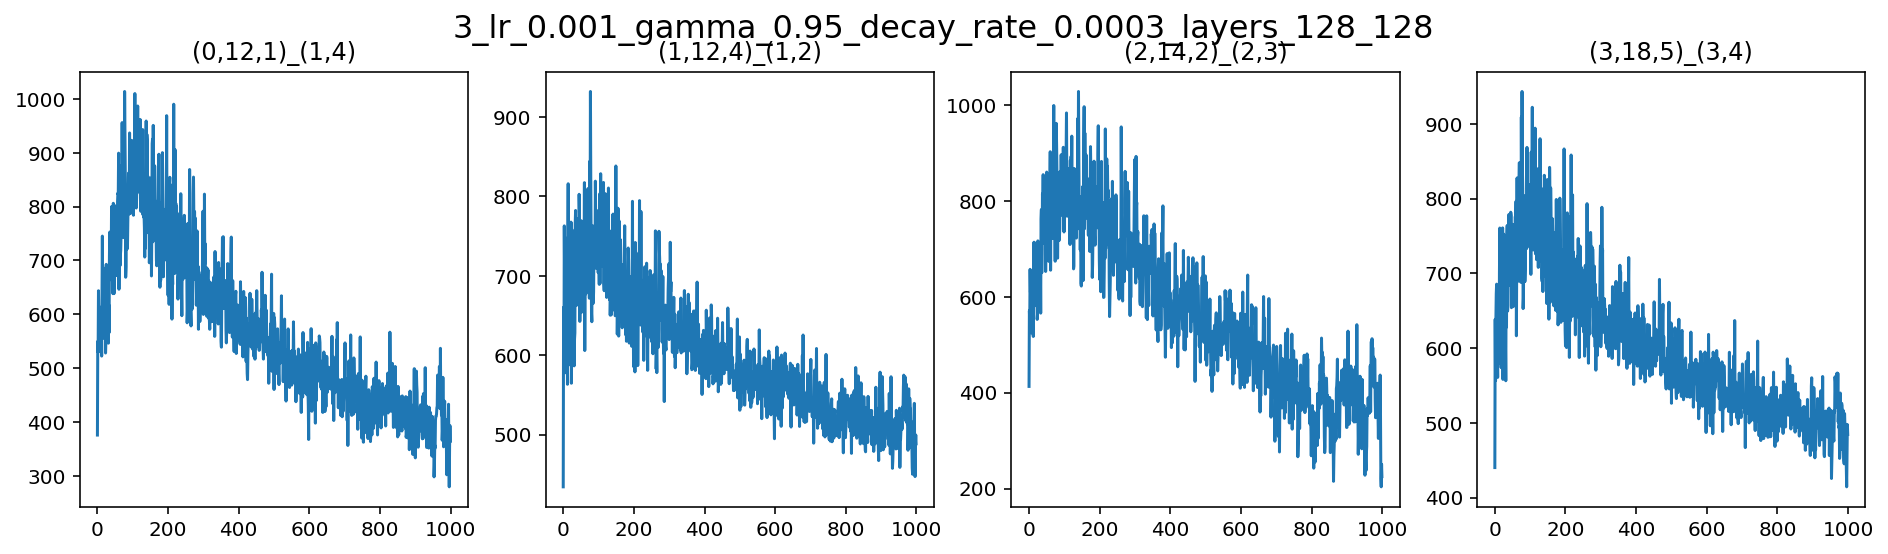

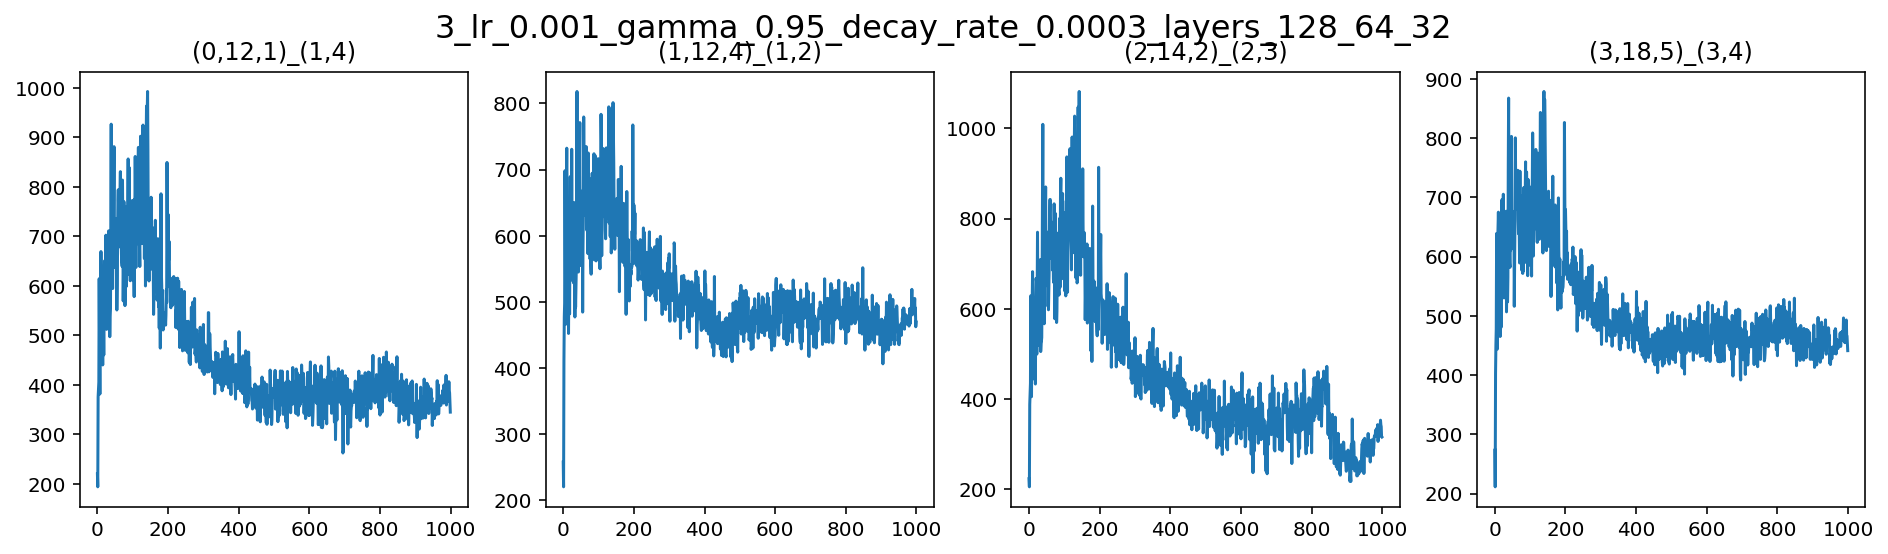

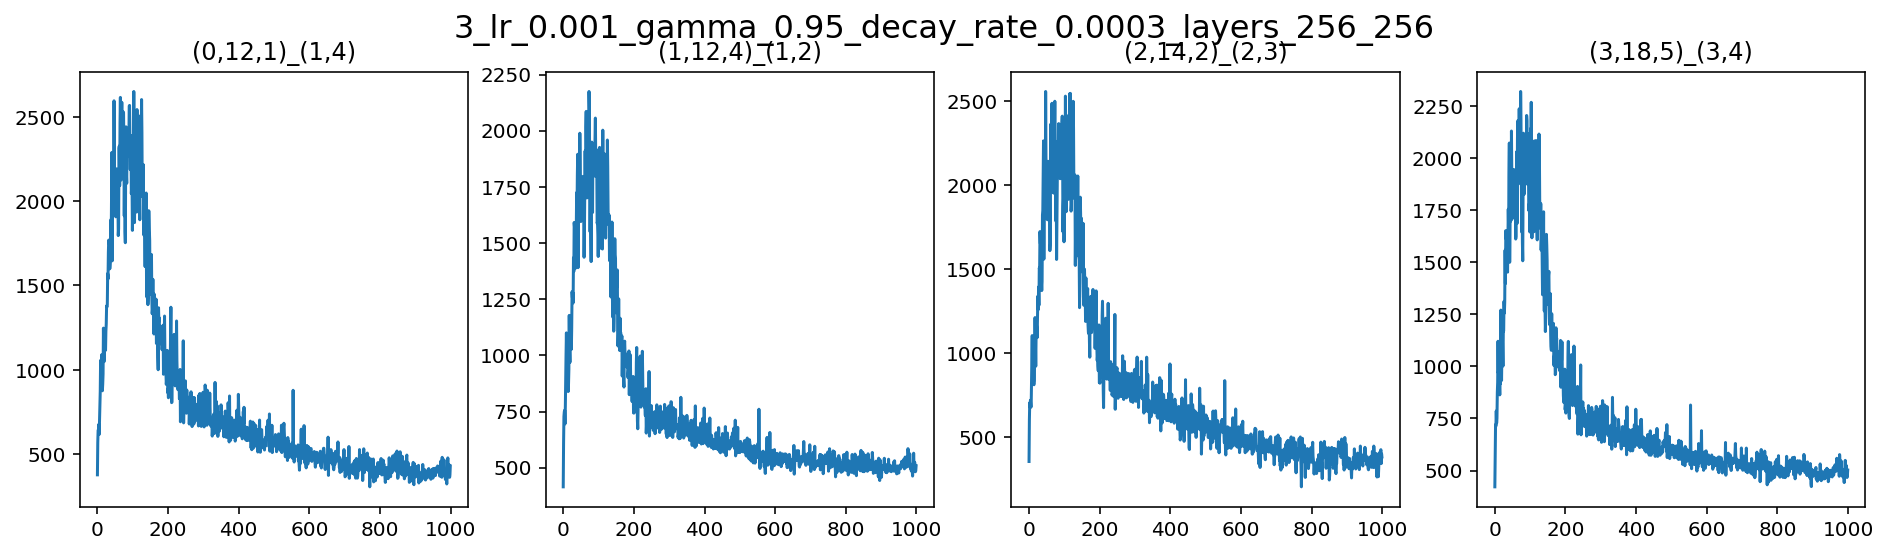

In [22]:
for index, params in enumerate(hp_params):
    name = get_model_name(params)
    with open(data_folder + name + "_tracked_states.pkl", 'rb') as handle:
        tracked_states = pickle.load(handle)
    plot_tracked_values(tracked_states, name=name)

In [23]:
stats=None

In [24]:
def collect_stats(df):
    global stats
    if stats is not None:
        stats = pd.concat([stats, df], axis=0)
    else:
        stats = df
    return df

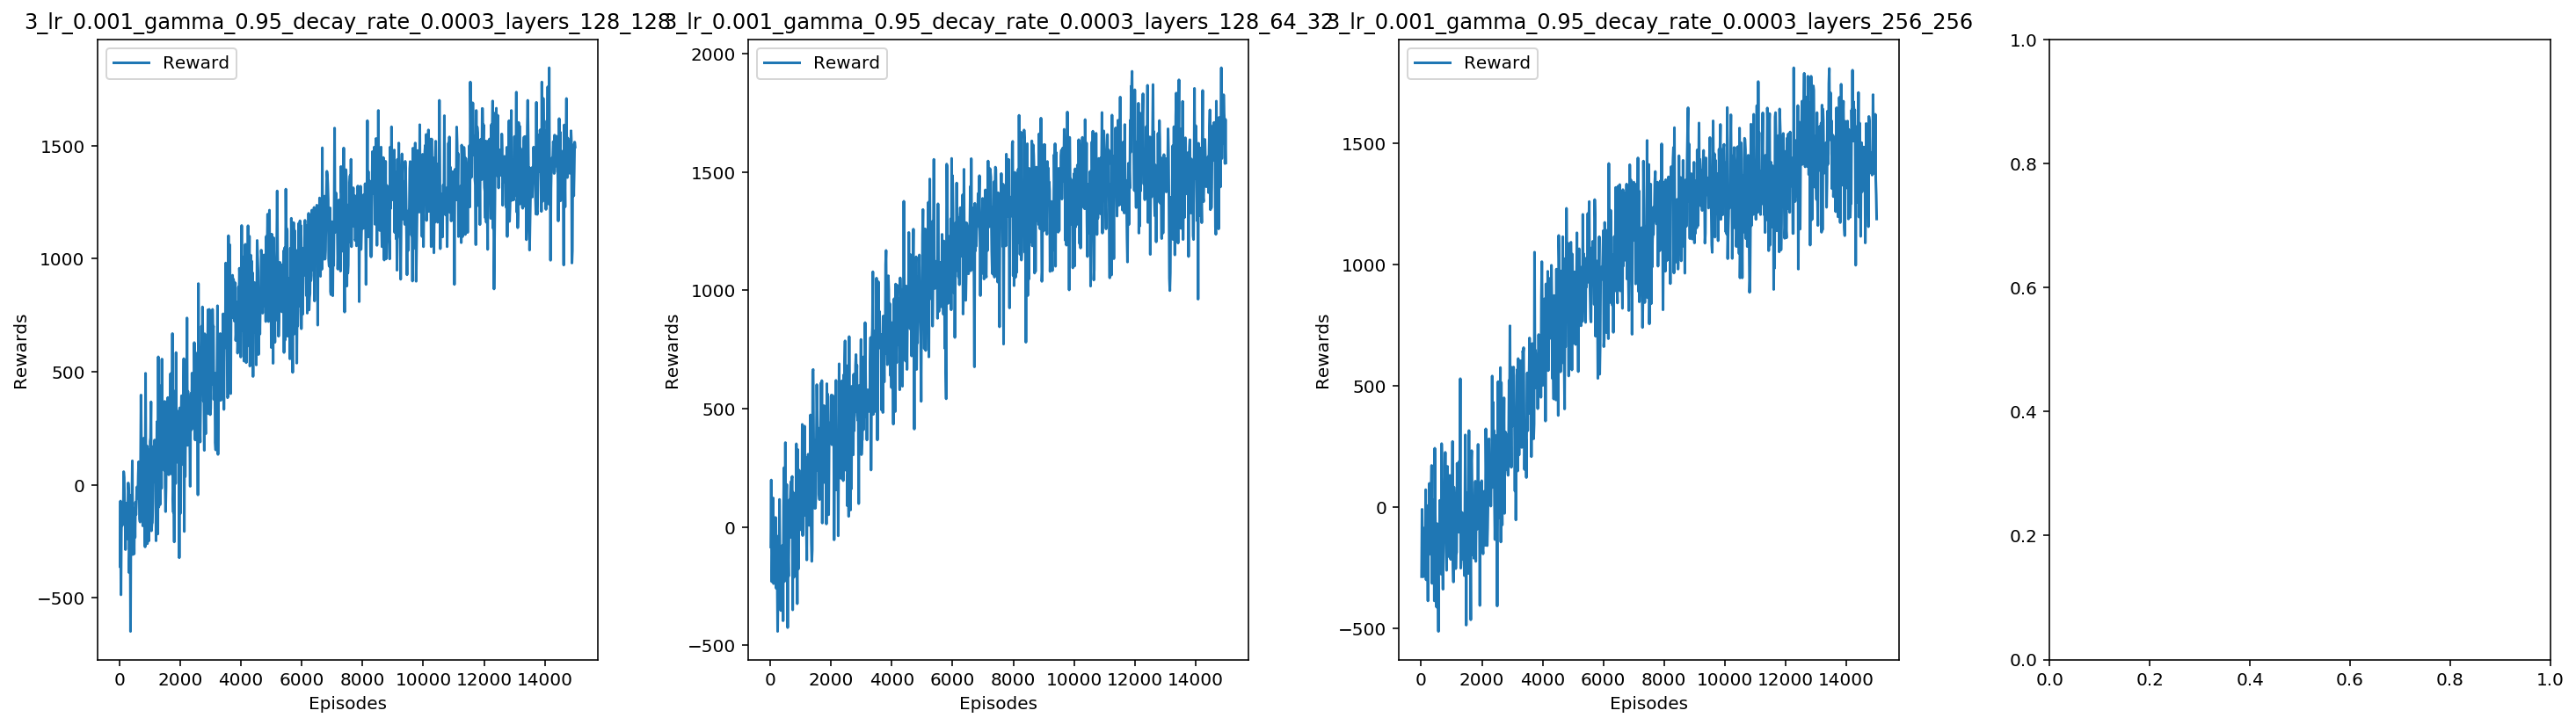

In [25]:
import math
columns = 4
rows = math.ceil(len(hp_params)/columns)
fig_height = rows * 5
fig, axs = plt.subplots(rows, columns, figsize=(25, fig_height))
df = None
for index, params in enumerate(hp_params):
    name = get_model_name(params)

    plt.subplot(rows, columns, index + 1, title=name)

    model_data = pd.read_csv(data_folder + name + ".csv")
    collect_stats(model_data)
    plt.plot(model_data['episode'], model_data['reward'], label='Reward')

    plt.title(name)
    plt.ylabel('Rewards')
    plt.xlabel('Episodes')
    plt.legend(loc="upper left")

plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.3)
plt.savefig('models_{}_3.png'.format(EPISODES))
plt.show()

In [26]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

df1 = stats.groupby('name').agg(avg_reward=('reward', np.mean),
                                max_reward=('reward',
                                            max)).sort_values('avg_reward',
                                                              ascending=False)
display(df1)

,avg_reward,max_reward
name,,
3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_64_32,1066.399,1941.0
3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_128_128,964.395,1845.0
3_lr_0.001_gamma_0.95_decay_rate_0.0003_layers_256_256,928.663,1812.0
